In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import numpy as np
from torchvision import datasets, transforms
from matplotlib import pyplot as plt 
from torch.utils.data import DataLoader
import os
from tensorflow import keras

from google.colab import drive 
drive.mount('sample_data/drive')

Mounted at sample_data/drive


In [ ]:
!unzip "sample_data/drive/MyDrive/Colab Notebooks/Lab_4/face-HQ.zip" -d "sample_data/drive/MyDrive/Colab Notebooks/Lab_4" 

Archive:  sample_data/drive/MyDrive/Colab Notebooks/Lab_4/face-HQ.zip
replace sample_data/drive/MyDrive/Colab Notebooks/Lab_4/face-HQ/test/1/39175.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [ ]:
batch_size = 32
epochs = 300

In [ ]:
learning_rate = .001

In [ ]:
train_dir = "sample_data/drive/MyDrive/Colab Notebooks/Lab_4/face-HQ/train"
test_dir = "sample_data/drive/MyDrive/Colab Notebooks/Lab_4/face-HQ/test"

train_transforms = transforms.Compose([transforms.ToTensor(),])
test_transforms = transforms.Compose([transforms.ToTensor(),])

train_val_data = datasets.ImageFolder(train_dir, transform = train_transforms)


train_data, validation_data = torch.utils.data.random_split(dataset = train_val_data, lengths = [2000, 700])
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

torch.Size([32, 3, 512, 512])
torch.Size([32, 3, 512, 512])


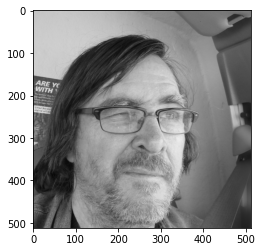

In [ ]:
#Test Grayscale Conversion
for data, target in train_loader:
  print(data.shape)
  #data = tf.image.rgb_to_grayscale(data[0].permute(1,2,0))
  gray_convert = transforms.Grayscale(num_output_channels = 3)
  gray_data = gray_convert(data)
  print(gray_data.shape)


  data.numpy()
  gray_data.numpy()
  plt.imshow(np.transpose(data[0].reshape((3,512,512)), (1,2,0)))
  plt.imshow(np.transpose(gray_data[0].reshape((3,512,512)), (1,2,0)))
  break

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(3,12,4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(12,24,4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(24,48,4, stride = 2, padding = 1),
        nn.ReLU(), 
        nn.Conv2d(48,96,4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(96,192,4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(192,384,4, stride = 2, padding = 1),
        nn.ReLU(),
        #nn.Conv2d(384,768,4, stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.Conv2d(768,1536,4, stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.Conv2d(1536,3072,4, stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.Conv2d(3072,6144,4, stride = 2, padding = 1),
        #nn.ReLU(),
    )

    self.decoder = nn.Sequential(
        #nn.ConvTranspose2d(6144,3072,4,stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.ConvTranspose2d(3072,1536,4,stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.ConvTranspose2d(1536,768,4,stride = 2, padding = 1),
        #nn.ReLU(),
        #nn.ConvTranspose2d(768,384,4,stride = 2, padding = 1),
        #nn.ReLU(),
        nn.ConvTranspose2d(384,192,4,stride = 2, padding = 1),
        nn.ReLU(),

        nn.ConvTranspose2d(192,96,4,stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(96,48,4,stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(48,24,4,stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(24,12,4,stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(12,3,4,stride = 2, padding = 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
path = "sample_data/drive/MyDrive/Colab Notebooks/Lab_4/Lab_4_Pro/checkpoint_pro"
device = torch.device('cuda:0')
net = Autoencoder().to(device)

for layer in net.modules():
  if isinstance(layer, nn.Conv2d):
    nn.init.kaiming_normal_(layer.weight, mode = 'fan_out')

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 30, verbose = True)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [120, 160, 200], gamma = 0.5)

# After first trials comment in the following lines
#checkpoint = torch.load(path)
#net.load_state_dict(checkpoint['model_state_dict'])
#net.eval()
#net.to(device)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#val_loss = checkpoint['val_loss']
#train_loss = checkpoint['train_loss']

In [ ]:
gray_convert = transforms.Grayscale(num_output_channels = 3)
for epoch in range(epochs):
  train_loss = 0
  val_loss = 0
  net.train()

  for data, target in train_loader:
    gray_data = gray_convert(data).to(device)
    data = data.to(device)

    outputs = net(gray_data)
    loss = criterion(outputs, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.data

  scheduler.step(loss)
  net.eval()
  with torch.no_grad():
    for data, target in validation_loader:
      data = data.to(device)
      outputs = net(data)
      loss = criterion(outputs, data)
      val_loss += loss.data


  torch.save({'epoch': epoch+1,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'val_loss': val_loss,
              'train_loss':train_loss}, path)
  
  print("Train Epochs: {}  Train Loss: {:.6f}  Validation Loss: {:.6f}  ".format(epoch+1, train_loss/len(train_loader), val_loss/len(validation_loader)))
  #writer.add_scalars('Loss', {'training loss': train_loss/len(train_loader), 'validation loss': val_loss/len(validation_loader)}, epoch + 1)

Train Epochs: 1  Train Loss: 0.066925  Validation Loss: 0.045031  
Train Epochs: 2  Train Loss: 0.023136  Validation Loss: 0.026082  
Train Epochs: 3  Train Loss: 0.015403  Validation Loss: 0.020341  
Train Epochs: 4  Train Loss: 0.013219  Validation Loss: 0.016516  
Train Epochs: 5  Train Loss: 0.011865  Validation Loss: 0.014921  
Train Epochs: 6  Train Loss: 0.011337  Validation Loss: 0.013874  
Train Epochs: 7  Train Loss: 0.011056  Validation Loss: 0.013749  
Train Epochs: 8  Train Loss: 0.010400  Validation Loss: 0.013999  
Train Epochs: 9  Train Loss: 0.010040  Validation Loss: 0.014262  
Train Epochs: 10  Train Loss: 0.009844  Validation Loss: 0.013562  
Train Epochs: 11  Train Loss: 0.009883  Validation Loss: 0.016165  
Train Epochs: 12  Train Loss: 0.009697  Validation Loss: 0.012647  
Train Epochs: 13  Train Loss: 0.009461  Validation Loss: 0.013195  
Train Epochs: 14  Train Loss: 0.009353  Validation Loss: 0.014582  
Train Epochs: 15  Train Loss: 0.009219  Validation Loss: 

In [ ]:
def plot_image_reconstruction(net, testloader):

  for batch in testloader:
    img, _ = batch
    img = img.to(device)
    outputs = net(img)

    img = img.view(img.size(0),3,512,512).cpu().data
    grid_img = torchvision.utils.make_grid(img, nrow = 8)
    plt.figure(figsize = [16,16])
    plt.imshow(grid_img.permute(1,2,0))

    outputs = outputs.view(outputs.size(0), 3, 512, 512).cpu().data
    grid_img = torchvision.utils.make_grid(outputs, nrow = 8)
    plt.figure(figsize = [16,16])
    plt.imshow(grid_img.permute(1,2,0))
    break

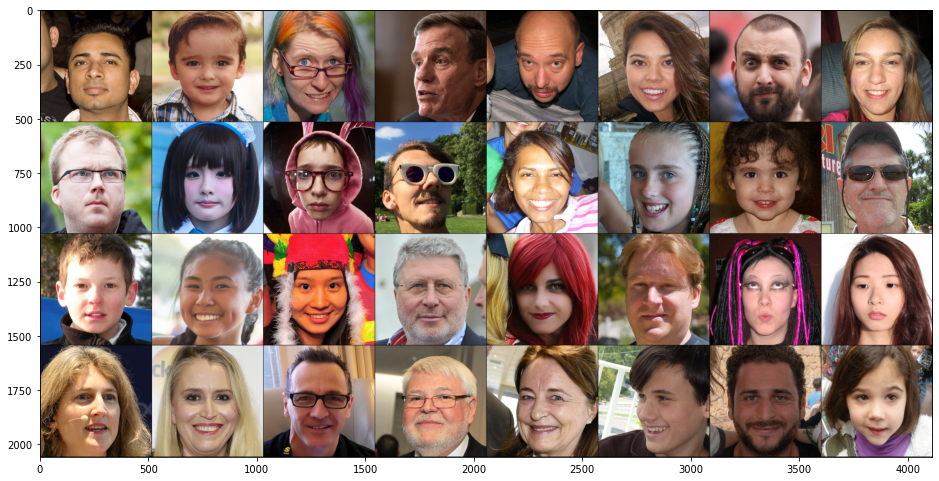

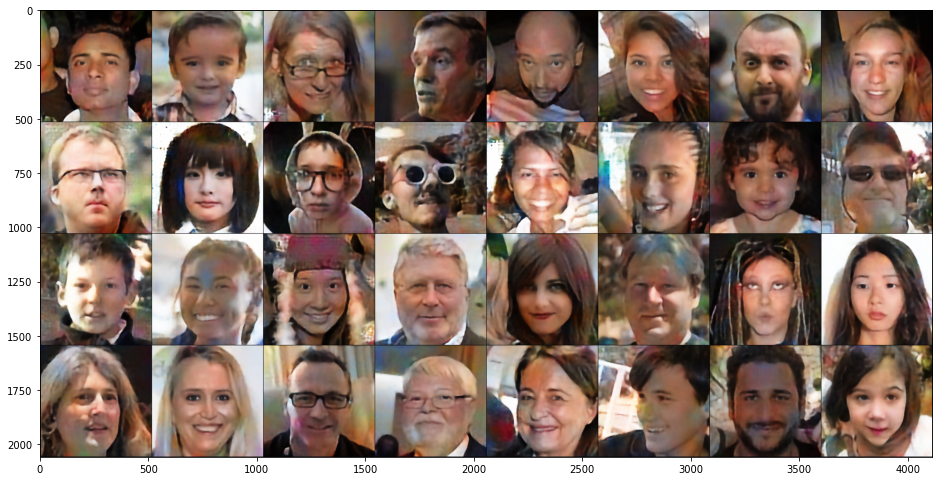

In [ ]:
plot_image_reconstruction(net, test_loader)